<h1 align="center"> Image Classifying from `CIFAR10` using `ResNet9` </h1>

### About dataset
The dataset is a collection of images of different objects separated in 10 folder as their classes.

### Content
The training dataset contains `50,000` and the test dataset contains `10,000` images of different objects. All the images have `3` channels (RGB) and the shape of the images are `32x32` pixels.

### Acknowledgements
- CIFAR10 dataset link - https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
- ResNet Implementation by pytorch - https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets
           

## Importing Libraries and create project

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name = "cifar10-resnet9"

## Preparing the CIFAR100 Dataset

Downloading and extracting the datasets, also see the classes

In [3]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train']
['truck', 'cat', 'automobile', 'frog', 'ship', 'bird', 'deer', 'horse', 'dog', 'airplane']


In [4]:
len(classes)

10

 Transforming data for the best and fast training output (Applying Normalization and Augmentation)

In [5]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [6]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
len(train_ds), len(valid_ds)

(50000, 10000)

In [7]:
# Chechking the shape of the images
img, label = train_ds[0]
img.shape

torch.Size([3, 32, 32])

Now, we create data loaders for retriving images in batches. Here we will use a larger batch size to use the larger portion of the GPU RAM.

In [8]:
batch_size = 128

In [9]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, pin_memory=True)

Let's see the images of a single batch from the training datsloader. For this we need to ***denormalize*** the pixels values to bring them back into the range `(0,1)`

In [10]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_image = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_image[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

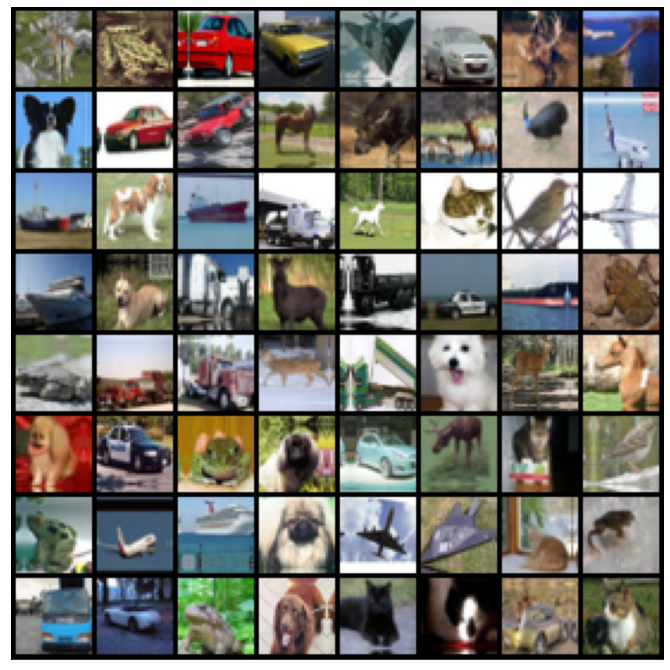

In [11]:
show_batch(train_dl)

## Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [13]:
# Move data to the selected device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Base image classification model

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

ResNet9 model for image classification

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)      # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)   # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # 128 x 16 x16
        
        self.conv3 = conv_block(128, 256, pool=True)  # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)  # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),    # 512 x 1 x 1
                                        nn.Flatten(),       # 512
                                        nn.Dropout(0.2),    # Drop 20% features to make it not overfit
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out = self.classifier(out6)
        return out

In [16]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.12109375, 'val_loss': 2.2993369102478027}]

In [19]:
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00139, train_loss: 1.3830, val_loss: 0.9794, val_acc: 0.6519
Epoch [1], last_lr: 0.00395, train_loss: 0.9792, val_loss: 1.7748, val_acc: 0.4645
Epoch [2], last_lr: 0.00703, train_loss: 0.8813, val_loss: 0.8584, val_acc: 0.7005
Epoch [3], last_lr: 0.00936, train_loss: 0.7270, val_loss: 0.7283, val_acc: 0.7631
Epoch [4], last_lr: 0.00999, train_loss: 0.6546, val_loss: 0.8167, val_acc: 0.7232
Epoch [5], last_lr: 0.00972, train_loss: 0.6217, val_loss: 0.9870, val_acc: 0.6842
Epoch [6], last_lr: 0.00908, train_loss: 0.5990, val_loss: 0.6262, val_acc: 0.7843
Epoch [7], last_lr: 0.00812, train_loss: 0.5815, val_loss: 0.6552, val_acc: 0.7833
Epoch [8], last_lr: 0.00691, train_loss: 0.5496, val_loss: 0.5813, val_acc: 0.8033
Epoch [9], last_lr: 0.00556, train_loss: 0.5131, val_loss: 0.5603, val_acc: 0.8138
Epoch [10], last_lr: 0.00416, train_loss: 0.4624, val_loss: 0.5196, val_acc: 0.8240
Epoch [11], last_lr: 0.00283, train_loss: 0.4009, val_loss: 0.4507, val_acc: 0.8509
Ep

### Plotting the training informations

In [21]:
# Plot accuracy for epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# plot train and validation in a single plot
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Plot learning rate
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

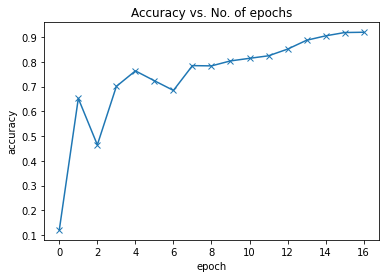

In [22]:
plot_accuracies(history)

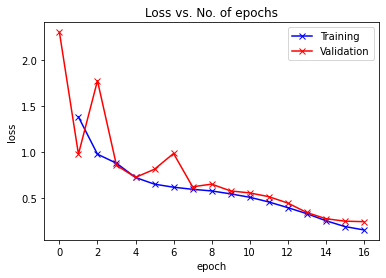

In [23]:
plot_losses(history)

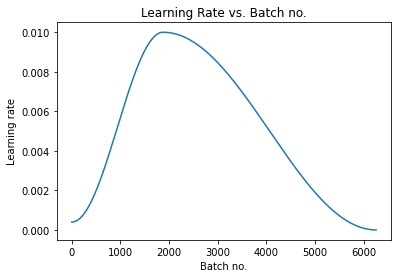

In [24]:
plot_lrs(history)

## Testing with individual images

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


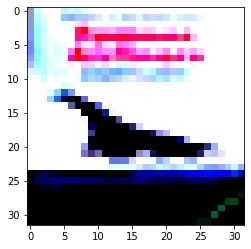

In [26]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


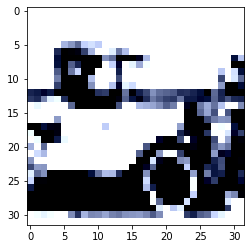

In [27]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


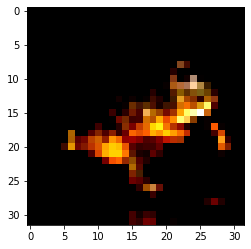

In [28]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

## Save the Model

In [29]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

## Conclusion and Further Work
- The model can now detect object from CIFAR10 Dataset.
- This is a project for the assignment of Deep learning Course on Jovian
- It can further improved to classify all the 100 subclasses.
- This was my first attempt at a fully working project and I plan on expanding my knowledge in the field of image segmentation and obejct detection.